# SQL vs NoSql vs NewSql

This notebook is used to run code and generate graphs

### Config

In [1]:
num_of_runs = 3

### Imports

In [2]:
import subprocess
import os
import time
import re
import postgres_import as pos_i
import mysql_import as my_i
import memsql_import as mem_i

### Helper function to generate a bar plot graph

In [3]:
import numpy as np
from matplotlib import pyplot as plt

def bar_plot(data, items, colours, title):
    fig = plt.figure()

    width = .45
    ind = np.arange(len(data))
    
    plt.bar(0.3+ind, data, width=width, color=colours)
    plt.xticks(0.3+ind + width / 2, items)
    plt.title(title)

    fig.autofmt_xdate()

    plt.show()

### Helper function to run commands inside a shell

In [4]:
def run_command(command, verbose=True, save_mem=False):
    process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, shell=True)
    returncode = process.wait()
    output = ""
    if not(save_mem):
        output = process.stdout.read().decode('utf-8', 'replace').replace("\r", "").split("\n")
        if verbose: 
            for line in output:
                print (line)
    return output

def run_command2(command, verbose=True, save_mem=False):
    process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
    returncode = process.wait()
    output = ""
    if not(save_mem):
        output = process.stdout.read().decode('utf-8', 'replace').replace("\r", "").split("\n")
        if verbose: 
            for line in output:
                print (line)
    return output

## Starting all the docker containers to check if it's all right

In [5]:
_ = run_command('D: && cd "D:\GitHub\BigData\Project2\Docker" && docker-compose up -d')

voltdb is up-to-date
memsql is up-to-date
Creating mysql
Creating cockroach
Creating nuodb
Creating orientdb
Creating trafodion
Creating neo4j
Creating redis
Creating mongo
Creating cassandra
Creating postgres



We will need the local ip of the Coackroach container for later use.

In [6]:
ip = run_command('docker exec cockroach ip route', verbose=False)
ip = ip[len(ip)-2].split(" ")
ip = ip[len(ip)-2]
coackroach_ip = ip
print(coackroach_ip)

172.18.0.9


## Stopping all the containers
Test functions will start and stop the containers many times in order to accurately measure times.

In [7]:
_ = run_command('D: && cd "D:\GitHub\BigData\Project2\Docker" && docker-compose down')

Stopping postgres ... 
Stopping cassandra ... 
Stopping mongo ... 
Stopping redis ... 
Stopping cockroach ... 
Stopping nuodb ... 
Stopping trafodion ... 
Stopping orientdb ... 
Stopping mysql ... 
Stopping neo4j ... 
Stopping voltdb ... 
Stopping memsql ... 
Stopping mongo ... doneStopping nuodb ... doneStopping redis ... doneStopping cockroach ... doneStopping neo4j ... doneStopping voltdb ... doneStopping orientdb ... doneStopping postgres ... doneStopping memsql ... doneStopping cassandra ... doneStopping trafodion ... doneStopping mysql ... doneRemoving postgres ... 
Removing cassandra ... 
Removing mongo ... 
Removing redis ... 
Removing cockroach ... 
Removing nuodb ... 
Removing trafodion ... 
Removing orientdb ... 
Removing mysql ... 
Removing neo4j ... 
Removing voltdb ... 
Removing memsql ... 
Removing mongo ... doneRemoving mysql ... doneRemoving orientdb ... doneRemoving cockroach ... doneRemoving redis ... doneRemoving memsql ... doneRemoving nuodb ... doneRemoving trafod

## Definitions

In [8]:
postgres_container = "postgres"
containers = ["mongo", "redis", "neo4j", "orientdb", "cassandra", postgres_container, "mysql", "memsql", "voltdb", "cockroach"]
colours = ["lightgreen", "red", "deepskyblue", "orange", "skyblue", "lightsteelblue", "steelblue", "cornflowerblue", "firebrick", "darkgreen"]

### Helper functions to run tests and measure the time taken

In [9]:
def exec_and_time(container, command, verbose=True, save_mem=False):
    start = time.time()
    if container == postgres_container or container == "mysql" or container == "memsql":
        command[0](os.path.join(os.path.abspath('./Docker/shared_data'),command[1]))
    elif container == "cockroach":
        _ = run_command('docker exec --privileged ' + container + ' sh -c "' + command[0] + '"', verbose, save_mem)
        _ = run_command('docker exec --privileged --user postgres '+ postgres_container +' sh -c "' + command[1] + '"', verbose, save_mem)
    elif container == "cassandra":
        _ = run_command2('docker exec --privileged ' + container + ' '+ command[0] +' -c "' + command[1] + '"', verbose, save_mem)
    else: 
        _ = run_command('docker exec --privileged ' + container + ' sh -c "' + command + '"', verbose, save_mem)
    end = time.time()
    return end - start

In [10]:
def average_time(commands, containers, iterations, verbose=True, import_data=False):
    times = [0] * len(containers)
    peak_times = [0] * len(containers)
    for j in range(0, iterations):
        if verbose:
            print("iteration " + str(j+1))
        _ = run_command('D: && cd "D:\GitHub\BigData\Project2\Docker" && docker-compose up -d', verbose=False)
        if verbose:
            print("waiting...")
        time.sleep(25) 
        for i in range(0, len(containers)):
            if verbose:
                print(containers[i])
            if import_data:
                exec_and_time(containers[i], data_import_commands[i], verbose=False, save_mem=True)
            time_taken = exec_and_time(containers[i], commands[i], verbose=False, save_mem=True)
            times[i] += time_taken
            if peak_times[i] < time_taken:
                peak_times[i] = time_taken
        _ = run_command('D: && cd "D:\GitHub\BigData\Project2\Docker" && docker-compose down', verbose=False)
    for i in range(0, len(containers)):
        times[i] = times[i]/iterations
        print(containers[i] + ": " + str(times[i]))
    return (times, peak_times)

## Average bulk import time

### Import commands

In [11]:
data_import_commands = [
    "mongoimport --db testing_db --collection customers --type csv --headerline --file /shared_data/mock_data_10000_rows.csv",
    "cat /shared_data/mock_data_10000_rows2.csv | redis-cli --pipe",
    "cp /shared_data/mock_data_10000_neo.csv /var/lib/neo4j/import && cat /shared_scripts/import_mock_10000.cypher | /var/lib/neo4j/bin/cypher-shell",
    "/orientdb/bin/oetl.sh /shared_scripts/import_orient_10000.json",
    ["bash", "cqlsh -f /shared_scripts/import_mock_10000.cql"],
    [pos_i.sql_import, "mock_data_10000_rows_utf8.csv"], #postgres
    [my_i.sql_import, "mock_data_10000_rows_utf8.csv"], #mysql
    [mem_i.sql_import, "mock_data_10000_rows_utf8.csv"], #memsql
    "cat /shared_scripts/import_voltdb.sql | sqlcmd && /opt/voltdb/bin/csvloader customers -f /shared_data/mock_data_10000_rows.csv",
    ["./cockroach sql --insecure --execute='create database if not exists mock;'", "psql -p 26257 -h "+ coackroach_ip +" -d mock -U root < /shared_data/postgres_dump.sql"]
]

#### Iterating

In [12]:
(import_times_avg, import_times_peak) = average_time(data_import_commands, containers, num_of_runs)

iteration 1
waiting...
mongo
redis
neo4j
orientdb
cassandra
postgres
mysql
memsql
voltdb
cockroach
iteration 2
waiting...
mongo
redis
neo4j
orientdb
cassandra
postgres
mysql
memsql
voltdb
cockroach
iteration 3
waiting...
mongo
redis
neo4j
orientdb
cassandra
postgres
mysql
memsql
voltdb
cockroach
mongo: 1.4092012246449788
redis: 0.3463412920633952
neo4j: 5.820218642552693
orientdb: 17.998886505762737
cassandra: 4.4498982429504395
postgres: 4.46457854906718
mysql: 1.4065825939178467
memsql: 3.709845542907715
voltdb: 6.5706201394399
cockroach: 0.9623019695281982


### Results

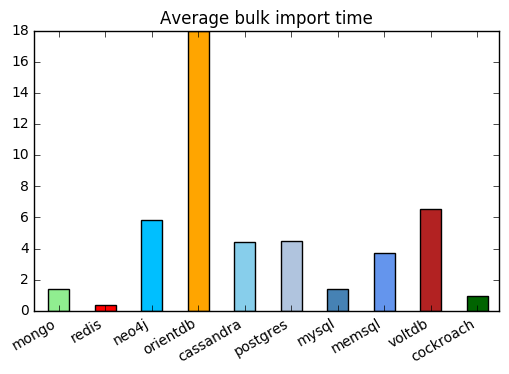

In [13]:
bar_plot(import_times_avg, containers, colours, "Average bulk import time")

## Query execution time and throughput

First we need to get some random _ids from mongo in order to test the indexed search time.

In [14]:
def get_mongo_ids(test=False):
    if test:
        _ = run_command('D: && cd "D:\GitHub\BigData\Project2\Docker" && docker-compose up -d mongo')
        time.sleep(5) 
    query_results = run_command(r"""docker exec --privileged mongo mongo testing_db --eval "db.customers.find({first_name:'Hosea'}).pretty().shellPrint();" """, verbose=test)
    mongo_ids = [x[2:-2] for x in re.findall('\(.*?\)', ' '.join(query_results))]
    if test:
        _ = run_command('D: && cd "D:\GitHub\BigData\Project2\Docker" && docker-compose down mongo')
    return mongo_ids

#print ("Test: ")
#get_mongo_ids(True) #test

### Helper functions, modified from the previous ones
And also dependant from them.

In [15]:
def exec_and_time2(container, command, verbose=True, save_mem=False):
    start = time.time()
    if container == "cassandra":
        _ = run_command2(command, verbose, save_mem)
    else:
        _ = run_command(command, verbose, save_mem)
    end = time.time()
    return end - start

In [16]:
def average_time2(commands, containers, iterations, verbose=True, import_data=True):
    times = [0] * len(containers)
    peak_times = [0] * len(containers)
    for j in range(0, iterations):
        if verbose:
            print("iteration " + str(j+1))
        _ = run_command('D: && cd "D:\GitHub\BigData\Project2\Docker" && docker-compose up -d', verbose=False)
        if verbose:
            print("waiting...")
        time.sleep(25) 
        for i in range(0, len(containers)):
            if verbose:
                print(containers[i])
            if import_data:
                exec_and_time(containers[i], data_import_commands[i], verbose=False, save_mem=True)
            if containers[i] == "mongo":
                m_id = get_mongo_ids()[1]; # for indexed read
            time_taken = exec_and_time2(containers[i], commands[i].replace("{{id}}", str(m_id)), verbose=False, save_mem=True)
            times[i] += time_taken
            if peak_times[i] < time_taken:
                peak_times[i] = time_taken
        _ = run_command('D: && cd "D:\GitHub\BigData\Project2\Docker" && docker-compose down', verbose=False)
    for i in range(0, len(containers)):
        times[i] = times[i]/iterations
        print(containers[i] + ": " + str(times[i]))
    return (times, peak_times)

### Unindexed Search Commands
Redis has no unindexed search.

In [17]:
unindexed_read_commands = [
    r"""docker exec --privileged mongo mongo testing_db --eval "db.customers.find({first_name:'Hosea'}).pretty().shellPrint();" """,
    "",
    r"""docker exec --privileged neo4j sh -c "echo \"MATCH (n) WHERE n.firstName = 'Hosea' RETURN n;\" | /var/lib/neo4j/bin/cypher-shell" """,
    r"""docker exec --privileged orientdb /orientdb/bin/console.sh "connect plocal:/temp/databases/mock admin admin; select from Customer where first_name = 'Hosea' " """,
    r"""docker exec --privileged cassandra cqlsh -k mock_keyspace -e "select * from customers where first_name = 'Hosea' allow filtering;" """,
    r"""docker exec --privileged postgres sh -c "echo \"SELECT * FROM customers WHERE first_name = 'Hosea'\" | psql -U postgres mock" """, #postgres
    r"""docker exec --privileged mysql mysql -u root --password=password --database mock -e "SELECT * FROM customers where first_name = 'Hosea'" """,
    r"""docker exec --privileged memsql memsql-shell --database mock -e "SELECT * FROM customers where first_name = 'Hosea'" """,
    r"""docker exec --privileged voltdb sh -c "echo \"select * from customers where first_name = 'Hosea';\" | sqlcmd"  """,
    r"""docker exec --privileged coackroach ./cockroach sql --insecure --execute="SET DATABASE = mock; SELECT * FROM customers WHERE first_name = 'Hosea';" """ 
]

#### Iterating

In [18]:
(unindexed_read_times_avg, unindexed_read_times_peak) = average_time2(unindexed_read_commands, containers, num_of_runs)
unindexed_read_times_avg[1] = 0; # redis has no unindexed search

iteration 1
waiting...
mongo
redis
neo4j
orientdb
cassandra
postgres
mysql
memsql
voltdb
cockroach
iteration 2
waiting...
mongo
redis
neo4j
orientdb
cassandra
postgres
mysql
memsql
voltdb
cockroach
iteration 3
waiting...
mongo
redis
neo4j
orientdb
cassandra
postgres
mysql
memsql
voltdb
cockroach
mongo: 0.30733362833658856
redis: 0.007000446319580078
neo4j: 2.542172908782959
orientdb: 3.403667608896891
cassandra: 0.726693312327067
postgres: 0.26254796981811523
mysql: 0.21873784065246582
memsql: 0.7752095063527426
voltdb: 0.61465851465861
cockroach: 0.045345147450764976


### Results

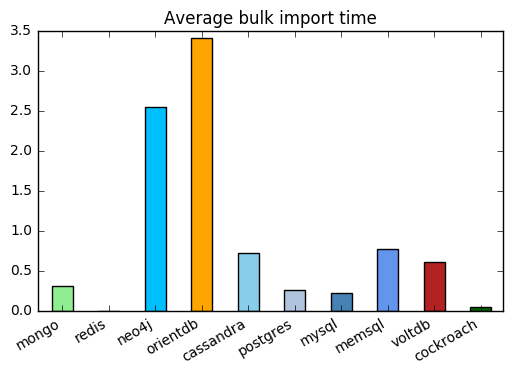

In [19]:
bar_plot(unindexed_read_times_avg, containers, colours, "Average bulk import time")